In [1]:
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg

import glob, requests, json, re, netrc

In [2]:
all_scans = []
all_detections = []

for f in glob.glob("scans/*json"):
    
    fi = int(re.sub(r"scans\/([0-9]{5}).json", r"\1", f))

    with open(f) as obj: j = json.load(obj)

    df = pd.DataFrame(j["bssid"])
    df.rename(columns = {"macAddress" : "bssid",
                         "signalStrength" : "rssi"}, 
              inplace = True)

    df["scan"] = fi
    df["lat"]  = j["lat"]
    df["lon"]  = j["lon"]
    
    all_scans.append([j["lat"], j["lon"], len(j["bssid"])])
    all_detections.append(df)
    
all_scans = pd.DataFrame(columns = ["lat", "lon", "N"], 
                              data = all_scans)

geom = gpd.GeoSeries([Point(xy) for xy in zip(all_scans.lon, all_scans.lat)], 
                     crs = from_epsg(4326)).to_crs(epsg = 3528)

all_scans = gpd.GeoDataFrame(data = all_scans, geometry = geom, crs = from_epsg(3528))


all_detections = pd.concat(all_detections, sort = False)
all_detections.sort_values(by = ["bssid", "rssi"], inplace = True)
all_detections.query("bssid != '00:00:00:00:00:00'", inplace = True)
all_detections.reset_index(inplace = True, drop = True)

geom = gpd.GeoSeries([Point(xy) for xy in zip(all_detections.lon, 
                                              all_detections.lat)], 
                     crs = from_epsg(4326)).to_crs(epsg = 3528)

all_detections = gpd.GeoDataFrame(data = all_detections, 
                                  geometry = geom, crs = from_epsg(3528))

#### Street network for Hyde Park

In [3]:
# %%bash

# wget -nv 'https://overpass-api.de/api/interpreter?data=(way["highway"](41.7911187,-87.5909545,41.8113041,-87.5656831);way["railway"](41.7911187,-87.5909545,41.8113041,-87.5656831););out body;>;out skel qt;' -O ways.osm
# ogr2ogr --config OSM_USE_CUSTOM_INDEXING NO -f GeoJSON streets.geojson  ways.osm  lines

Save some levels for the importance of various ways.

In [4]:
streets = gpd.read_file("streets.geojson")
streets = streets[streets.centroid.x < -80]
streets.to_crs(epsg = 3528, inplace = True)

level = {'motorway' : 1, 'motorway_link' : 1,
         'trunk' : 1, 'trunk_link' : 1,
         'primary' : 1, 'primary_link' : 1,
         'secondary' : 1, 'secondary_link' : 1,
         'tertiary' : 2, 'tertiary_link' : 2,
         'residential' : 3,
         'service' : 4.5, 'footway' : 4, 'path' : 4, 
         'steps' : 4, 'cycleway' : 4, 'pedestrian' : 4, 
         None: 5}

streets["highway_level"] = streets.highway.replace(level)
streets["highway_thickness"] = 5 - streets["highway_level"]

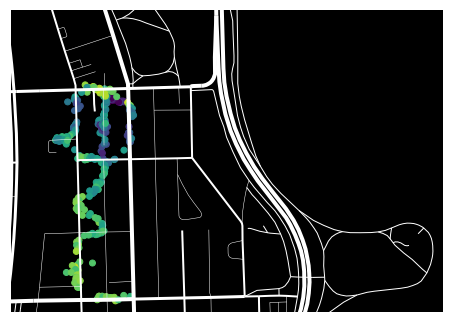

In [5]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

all_scans.plot(column = "N", # legend = True, 
               ax = ax,
               vmin = 50, vmax = 120)

streets.plot(color = "w", lw = streets.highway_thickness, ax = ax)

ax.set_xlim(362000, 363000)
# ax.set_ylim(569000, 570750)
ax.set_ylim(569600, 570300)

ax.set_facecolor("k")

map_format(ax)

fig.savefig("wifi_walk.pdf", facecolor = "k", edgecolor='none', 
            bbox_inches='tight', pad_inches=0.025)

#### How many unique BSSIDs?

Note that there are often many on a single router, e.g., for xfinitywifi and perhaps multiple channels.  They typically vary by just a few digits on the BSSID.

In [6]:
len(all_detections.bssid.unique())

2342

In [7]:
all_detections_U = all_detections.dissolve("bssid")[["geometry"]]
all_detections_U.set_geometry(all_detections_U.centroid, inplace = True)

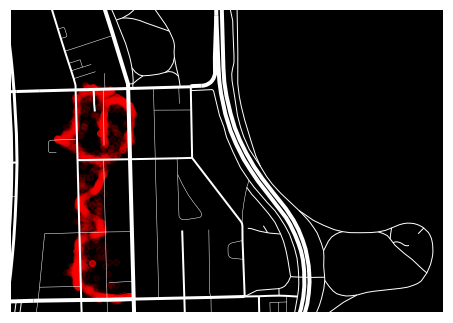

In [8]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

all_detections_U.plot(color = "r", alpha = 0.1, ax = ax)
streets.plot(color = "w", lw = streets.highway_thickness, ax = ax)

ax.set_xlim(362000, 363000)
# ax.set_ylim(569000, 570750)
ax.set_ylim(569600, 570300)

ax.set_facecolor("k")

map_format(ax)

fig.savefig("wifi_centroids.pdf", facecolor = "k", edgecolor='none', 
            bbox_inches='tight', pad_inches=0.025)

Alternate strategy is to just send every one of these to google individually.  Realistically, this would not be very expensive and it would be more accurate.  Is it necessary?

#### Try asking Google for the location of a single device...

In [9]:
from wifi_mapping import *

with open("scans/00001.json") as obj: j = json.load(obj)

It doesn't respond.

In [10]:
j["bssid"][:2]

[{'macAddress': '3c:b7:4b:8c:ac:9d', 'signalStrength': -39},
 {'macAddress': '3c:b7:4b:8c:ac:9b', 'signalStrength': -40}]

In [11]:
get_location(addresses = j["bssid"][:1])

{'error': {'code': 404,
  'errors': [{'domain': 'geolocation',
    'message': 'Not Found',
    'reason': 'notFound'}],
  'message': 'Not Found'}}

But of course we can sometimes cheat and ask about multiple BSSIDs on the same physical device.

In [12]:
js = sorted(j["bssid"], key = lambda x : x["macAddress"])

js = [jsi for jsi in js if "a0:0d:cb:8c" in jsi["macAddress"]]
js

[{'macAddress': 'c0:a0:0d:cb:8c:5a', 'signalStrength': -66},
 {'macAddress': 'c0:a0:0d:cb:8c:5b', 'signalStrength': -75},
 {'macAddress': 'd2:a0:0d:cb:8c:5b', 'signalStrength': -75}]

In [13]:
get_location(addresses = js)

{'accuracy': 34, 'location': {'lat': 41.7993318, 'lng': -87.5843}}

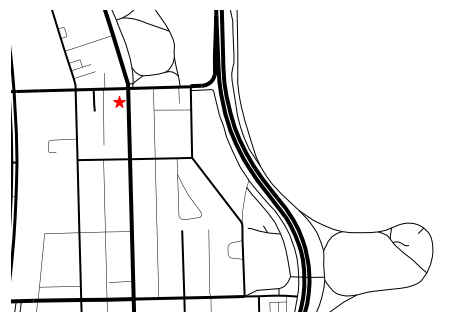

In [14]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

streets.plot(color = "k", lw = streets.highway_thickness, ax = ax)

gs = gpd.GeoSeries([Point(-87.5843, 41.7993318)], 
                   crs = from_epsg(4326)).to_crs(epsg = 3528)

gs.plot(ax = ax, marker = "*", markersize = 150, color = "red")

ax.set_xlim(362000, 363000)
ax.set_ylim(569600, 570300)

map_format(ax)

Home sweet home, kitchen window...